### 프롬프트

```
각 기업명을 키워드로 하여 기사를 수집하고, 수집한 기사를 전처리하였다. 전처리가 완료된 기사를 대상으로, 각 기업별 ESG활동을 정량적으로 평가하고자 한다. 최종 목표는 텍스트마이닝 기반 방식으로 측정한 기업별 ESG 섹터별 점수를 바탕으로, ESG 중심 투자자에게 포트폴리오를 제공하는 것입니다. 이는 당신과 소통을 원활하게 하기 위한 저의 작업 현황과 목표를 공유하는 것이며, 지금은 전처리나 아래의 1,2,3단계 작업, 서비스화 단계는 논의에서 제외하고, 아래에서 설명하는 4,5,6단계의 구체적 방법 수립 및 요구되는 코드 작성을 중심으로 도움을 요청합니다. 이제 각 단계를 설명할테니, 전체를 읽고, 4,5,6,단계에서 필요한 작업을 수행할 수 있는 방법과 코드를 제공해주십시오.

1단계: 기사별 기업해당도 라벨링 (0.0~1.0)
OPENAI API를 이용하여 얼마나 해당 기업에 대한 내용인지 평가하고, 라벨 부여 (=>0.7만 취급)
예를 들어, 4개의 기사에 대해 기업해당도 라벨링 결과는 다음과 같이 라벨링되었다고 가정하자.
 score_match
articleA 1
articleB 0.8
articleC 0.9
articleD 0.5
articleE 1
articleF 0.7
이 경우 해당도의 임계값을 0.7로 필터링하여 이 값보다 작은(0.7까지는 포함) 기사는 스코어링 작업에서 제외한다.

2단계: 기사별 각 ESG 섹터별 긍부정도(score_e, score_s, score_g) 라벨링 (-1.0~+1.0)
OPENAI API를 이용하여 얼마나 각 ESG 섹터별(E,S,G 각각) 긍부정 이슈인지 평가하고, 라벨 부여 (단, 무관한 섹터는 none값부여) 예를 들어, 3개의 기사에 대해 각 섹터(E,S,G각각)별 긍부정도 라벨링 결과는 그 기사의 내용을 API가 평가함에 따라 다음과 같이 라벨링될 수 있다.
 score_e, score_s, score_g
articleA -1 1 -0.5
articleB 0.5 0 none
articleC 0 none none
articleD -1 1 -0.5
articleE 0.5 0 1
articleF 0 none 0

3단계: 각 섹터별 ESG 스코어 산출
score_match, score_e, score_s, score를 바탕으로, 각 섹터별 ESG 점수를 산출한다.
이때 각 섹터별 점수를 먼저 산출한다. 단, 각 섹터별 ESG 점수 값에 해당 섹터에 점수가 있는 기사의 수로 가중평균을 적용하여 기업별 종합 ESG 스코어를 산출한다. 다시 말해, 섹터별 점수를 산출할 때, none으로 평가된 기사는 해당 섹터의 점수 산출과정에 한해서는 없는 기사로 취급(연산에서 제외)한다. 이때 먼저 각 섹터별로 기사를 랜덤으로 k개만큼 추출해서 각 기사의 해당도(w)를 곱연산 한 후, 그 점수를 평균한 값 즉 (Σk*w)/n을 (= {Σ(각 기사의 섹터 점수*기업해당도) /해당 섹터에 점수가 있는 기사의수}) 구하는 작업을 m번 수행하여 그 결과를 평균낸 값  Σ{(Σk)/n}/m 이 각 기업의 종합 ESG 스코어가 된다.
예를 들어 전체 기사 n개 중에 추출한 k개의 3개의 기사가 article A,B,C이며 각 기사의 기업해당도 및 E,S,G점수가 각각 아래와 같을 때,
score_match score_e  score_s  score_g
articleA 1 -1 1 -0.5
articleB 0.8 0.5 0 none
articleC 0.9 0 none none
각 섹터별 ESG 점수는 긍부정도에 기업해당도를 곱한 값의 합을 기사의 수로 나누는 식으로, 다음과 같이 산출할 수 있다.
score_ew = {(-1*1+0.5*0.8+0*0.9)/3}
score_sw = {(1*1+0*0.8)/2}
score_gw = {(-0.5*1)/1}
이 작업을 m번 수행한 결과가 각각
score_ew1, score_ew2, score_ew3... (각 섹터별) 로 산출되었다고 할 때,
(score_ew1+score_ew2+score_ew3+...)/m = score_et = 기업의 E섹터 ESG스코어
와 같은 식으로 각 섹터별 점수를 산출한다.

4단계:  기업별 종합 ESG 스코어 및 섹터별 최적의 반영 비율 파라미터 탐색
3단계에서 구한 섹터별 점수 score_et, score_st, score_gt 를 평균한다.
3단계에서 이미 기사의 수로 가중평균 되었으나, 추가로 각 섹터별 반영 비율 파라미터(ep,sp,gp)의 최적의 조합을 찾는다.
( score_et*ep + score_st*sp + score_gt*gp )/3 = 기업의 종합 ESG 스코어
최적의 조합을 찾는 기준은 아래와 같다.
먼저 공신력 있는 ESG평가기관에서 측정한 각 기업별 ESG 점수를 수집한다. 이 점수는 수집이 완료되어 있다. 2개 기관의 점수를 수집하였는데, 각각의 기관 점수와 두 기관의 평균까지 총 3개의 기준을 활용한다. 기관점수를 정답 라벨로 해서, 여러 가중치 조합으로  잔차가 최소화되는 때의 가중치 조합을 채택 나아가 각 기업별 점수 전체 분포를 바탕으로 스케일링하여, 이 분포가 기관점수에 근사하는지 검토하고, 가장 잔차가 적은 상태의 분포가 형성되는 때의 계산식 및 섹터별 가중치( score_et, score_st, score_gt) 의 최적의 가중치 조합을 grid search로 산출한다. 추가로 (해당 섹터가 평가된 기사의 수/전체 기사의 수)를 하나의 가중치로 고려하여 포함하도록 가중치 반영 공식을 구성한다. 여기까지의 작업에서 파라미터를 각 기업별로 산출하고, 충분한 수의 기업(지금은 7개사) 에 대해 가중치 조합이 산출되면, 그때까지 산출된 조합(가중치)의 평균을 글로벌 조합으로 채택한다.
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
#/content/drive/MyDrive/Kwargs/관련도/esg_한온시스템.csv
df = pd.read_csv('/content/drive/MyDrive/Kwargs/관련도/esg_한온시스템.csv',encoding='cp949')
df.head()

,title,date,content,category,full_text,cluster,evaluation,e_sentiment,s_sentiment,g_sentiment
0,"한온시스템, 폭스바겐에 히트펌프 시스템용 부품 공급",2020-12-01 11:54,한온시스템이 독일 폭스바겐그룹의 전기차 전용 플랫폼 'MEB'에 공급하는 세부 부품...,생활문화,한온시스템 폭스바겐에 히트펌프 시스템용 부품 공급 한온시스템이 독일 폭스바겐그룹의 ...,13.0,0.9,0.9,0.8,0.8
1,"IPO 앞둔 나노팀, 안정적 성장 전망-유진",2023-02-14 8:05,전기차 배터리용 열관리에 최초로 국산 소재를 사용한 전문 업체로 탄탄한 기술력이 있...,경제,앞둔 나노팀 안정적 성장 전망유진 이데일리 최훈길 기자 내달 코스닥 시장 신규 상장...,13.0,0.9,0.9,0.8,0.8
2,"NH證, IB확대로 더 강력해진 IB 최강자",2019-02-19 6:11,"IPO(기업공개), 유상증자 등 ECM(주식자보시장) 침체에도 불구하고 회사채 발행...",경제,확대로 더 강력해진 최강자 머니투데이 김명룡 기자 제회 대한민국 대상최우수 주관사상...,11.0,0.9,0.8,0.8,0.8
3,돈 되는 '친환경'…주가도 그린라이트,2020-08-16 15:01,아이뉴스24 김종성 기자 코로나19 이후 국내 주식시장에서 ‘친환경’을 키워드로 하...,경제,돈 되는 친환경주가도 그린라이트 아이뉴스 김종성 기자 코로나 이후 국내 주식시장에서...,5.0,0.8,0.8,0.8,0.8
4,"이제 수소시대, 현대차와 밸류체인에 투자하세요",2020-10-30 10:21,머니투데이 김도윤 기자 그린뉴딜엑스포그린뉴딜서 찾는 새로운 투자 기회지금은 체감이 ...,경제,이제 수소시대 현대차와 밸류체인에 투자하세요 머니투데이 김도윤 기자 그린뉴딜엑스포그...,13.0,0.9,0.8,0.8,0.8


### 데이터 불러오기

In [ ]:
import os
import pandas as pd

# 폴더 경로 설정 (파일이 위치한 폴더 경로에 따라 수정)
folder_path = '/content/drive/MyDrive/Kwargs/관련도'

# 폴더 내의 모든 파일 목록 가져오기
file_list = os.listdir(folder_path)

# 특정 이름 뒤에 무작위의 문자가 추가된 파일을 필터링하여 데이터프레임으로 저장할 딕셔너리
dataframes = {}

# 파일 목록을 순회하며 특정 이름 뒤에 무작위의 문자가 추가된 파일들을 찾아 데이터프레임으로 읽어오기
for idx, file_name in enumerate(file_list):
    if file_name.startswith('esg') and file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path,encoding='cp949')
        # 변수명 설정
        var_name = f'df{idx}'
        dataframes[var_name] = df

# 각 데이터프레임의 헤더 출력
for var_name, df in dataframes.items():
    print(f"=== {var_name} ===")
    print(df.sample(2))
    print('\n')

In [ ]:
# 데이터프레임들을 담고 있는 딕셔너리
# 위에서 생성함

# 각 데이터프레임의 컬럼명을 변경하는 코드
column_mappings = {
    'evaluation': 'score_match',
    'e_sentiment': 'score_e',
    's_sentiment': 'score_s',
    'g_sentiment': 'score_g'
}

# 모든 데이터프레임에 대해 컬럼명 변경 적용
for df_name, df in dataframes.items():
    df.rename(columns=column_mappings, inplace=True)
    # 업데이트된 데이터프레임을 다시 딕셔너리에 저장
    dataframes[df_name] = df

# 업데이트된 데이터프레임 확인 (예시로 df2 출력)
print(dataframes['df2'].head())


                          title              date  \
0  한온시스템, 폭스바겐에 히트펌프 시스템용 부품 공급  2020-12-01 11:54   
1      IPO 앞둔 나노팀, 안정적 성장 전망-유진   2023-02-14 8:05   
2      NH證, IB확대로 더 강력해진 IB 최강자   2019-02-19 6:11   
3          돈 되는 '친환경'…주가도 그린라이트  2020-08-16 15:01   
4     이제 수소시대, 현대차와 밸류체인에 투자하세요  2020-10-30 10:21   

                                             content category  \
0  한온시스템이 독일 폭스바겐그룹의 전기차 전용 플랫폼 'MEB'에 공급하는 세부 부품...     생활문화   
1  전기차 배터리용 열관리에 최초로 국산 소재를 사용한 전문 업체로 탄탄한 기술력이 있...       경제   
2  IPO(기업공개), 유상증자 등 ECM(주식자보시장) 침체에도 불구하고 회사채 발행...       경제   
3  아이뉴스24 김종성 기자 코로나19 이후 국내 주식시장에서 ‘친환경’을 키워드로 하...       경제   
4  머니투데이 김도윤 기자 그린뉴딜엑스포그린뉴딜서 찾는 새로운 투자 기회지금은 체감이 ...       경제   

                                           full_text  cluster  score_match  \
0  한온시스템 폭스바겐에 히트펌프 시스템용 부품 공급 한온시스템이 독일 폭스바겐그룹의 ...     13.0          0.9   
1  앞둔 나노팀 안정적 성장 전망유진 이데일리 최훈길 기자 내달 코스닥 시장 신규 상장...     13.0          0.9   
2  확대로 더 강력해진 최강자 머니투데이 김명룡 기자 제회 대한민국 대상최우수 주관사상...    

###3단계: 각 섹터별 ESG 스코어 산출

In [ ]:
import pandas as pd
import numpy as np

# 각 데이터프레임에서 score_match > 0.7인 기사만 유지
for df_name, df in dataframes.items():
    filtered_df = df[df['score_match'] > 0.7]
    dataframes[df_name] = filtered_df  # 필터링된 데이터프레임을 원본 딕셔너리에 다시 저장

# 섹터별 ESG 점수 계산 함수
def calculate_esg_scores(df):
    results = {}
    sectors = ['e', 's', 'g']

    for sector in sectors:
        sector_scores = df.apply(lambda x: x['score_match'] * x[f'score_{sector}'] if pd.notnull(x[f'score_{sector}']) else np.nan, axis=1)
        valid_scores = sector_scores.dropna()
        if not valid_scores.empty:
            results[f'score_{sector}w'] = valid_scores.mean()
        else:
            results[f'score_{sector}w'] = np.nan

    return results

# 각 데이터프레임에 대해 ESG 점수를 계산하고 결과를 저장
all_esg_scores = {}

for df_name, df in dataframes.items():
    esg_scores = calculate_esg_scores(df)
    all_esg_scores[df_name] = esg_scores

# 결과 출력
for df_name, scores in all_esg_scores.items():
    print(f"ESG scores for {df_name}: {scores}")


ESG scores for df1: {'score_ew': 0.270374251497006, 'score_sw': 0.30462111801242236, 'score_gw': 0.2908848484848485}
ESG scores for df2: {'score_ew': 0.3058171745152355, 'score_sw': 0.3285077951002227, 'score_gw': 0.2827391304347826}
ESG scores for df3: {'score_ew': 0.29320411022886506, 'score_sw': 0.37396619496855343, 'score_gw': 0.3234731270358306}
ESG scores for df4: {'score_ew': 0.27987951807228917, 'score_sw': 0.3532737074246508, 'score_gw': 0.32321519632840395}
ESG scores for df5: {'score_ew': 0.16476554536187568, 'score_sw': 0.29907275320970045, 'score_gw': 0.23610353270374257}
ESG scores for df6: {'score_ew': 0.16655865921787713, 'score_sw': 0.28344685628742516, 'score_gw': 0.26156097560975605}
ESG scores for df7: {'score_ew': 0.3434862385321101, 'score_sw': 0.38270983213429255, 'score_gw': 0.34974025974025974}


### 평가기관 점수 데이터셋 테이블 생성


In [ ]:
# 실제 ESG 점수 데이터
# 가나다순으로 df1부터 7까지, '종목명': ['금호석유', '셀트리온', '아모레퍼시픽', '현대백화점', '카카오뱅크', '크래프톤', '한온시스템'] 이다.
esg_scores = pd.DataFrame({
    '종목명': ['금호석유', '셀트리온', '아모레퍼시픽', '카카오뱅크', '크래프톤', '한온시스템', '현대백화점'],
    'spglobal': [66, 69, 68, 26, 16, 59, 36],
    'sustainalytics': [19.1, 29.8, 29.5, 29.8, 17.5, 12, 21.1]
}, index=['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7'])

# sustainalytics 점수를 두 배로 계산
esg_scores['sustainalytics'] *= 2

# 두 기관의 평균 점수 계산
esg_scores['average'] = esg_scores[['spglobal', 'sustainalytics']].mean(axis=1)

# 확인을 위한 출력
esg_scores

,종목명,spglobal,sustainalytics,average
df1,금호석유,66,38.2,52.1
df2,셀트리온,69,59.6,64.3
df3,아모레퍼시픽,68,59.0,63.5
df4,카카오뱅크,26,59.6,42.8
df5,크래프톤,16,35.0,25.5
df6,한온시스템,59,24.0,41.5
df7,현대백화점,36,42.2,39.1


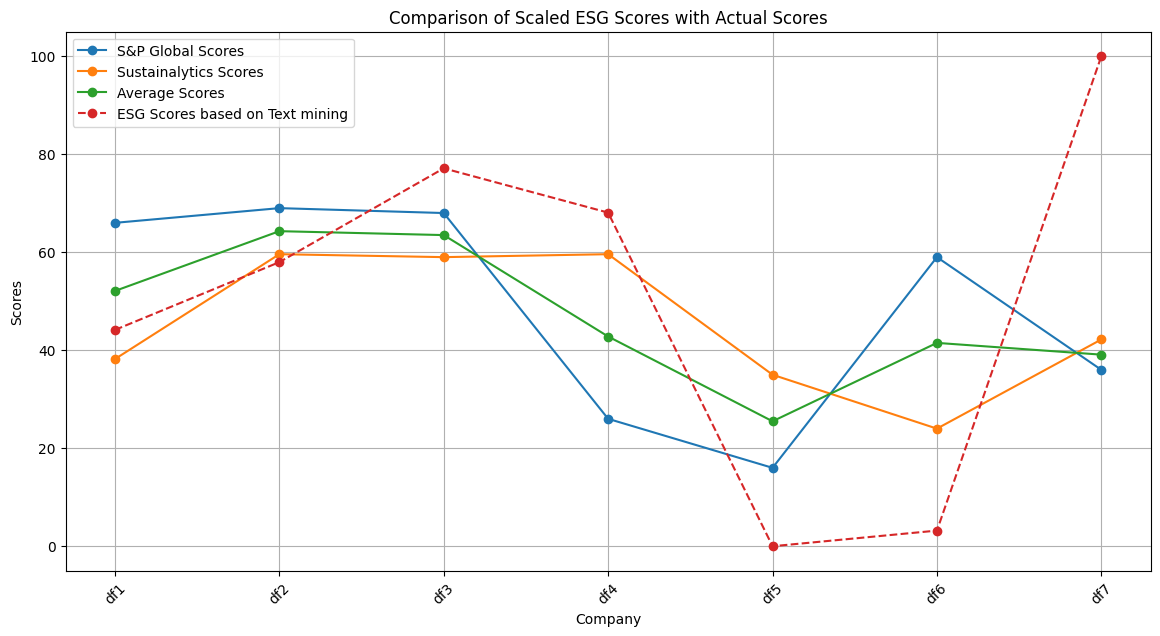

MSE with S&P Global Scores: 1417.1425337903383
MSE with Sustainalytics Scores: 776.7802237599428
MSE with Average Scores: 964.9756644894265


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 3단계에서 계산된 ESG 점수
esg_scores_3 = pd.DataFrame({
    'score_ew': [0.270, 0.306, 0.293, 0.280, 0.165, 0.167, 0.343],
    'score_sw': [0.305, 0.329, 0.374, 0.353, 0.299, 0.283, 0.383],
    'score_gw': [0.291, 0.283, 0.323, 0.323, 0.236, 0.262, 0.350]
}, index=['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7'])

# ESG 점수 합계를 계산
esg_scores_3['total_esg'] = esg_scores_3.sum(axis=1)

# 스케일링을 위해 MinMaxScaler 사용
scaler = MinMaxScaler(feature_range=(0, 100))
esg_scores_3['scaled_esg'] = scaler.fit_transform(esg_scores_3[['total_esg']])

# 스케일링 된 ESG 점수와 실제 점수 비교를 위한 데이터 프레임 준비
comparison_df = pd.concat([esg_scores, esg_scores_3[['scaled_esg']]], axis=1)

# 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['spglobal'], label='S&P Global Scores', marker='o')
plt.plot(comparison_df['sustainalytics'], label='Sustainalytics Scores', marker='o')
plt.plot(comparison_df['average'], label='Average Scores', marker='o')
plt.plot(comparison_df['scaled_esg'], label='ESG Scores based on Text mining', marker='o', linestyle='--')
plt.title('Comparison of Scaled ESG Scores with Actual Scores')
plt.xlabel('Company')
plt.ylabel('Scores')
plt.xticks(ticks=np.arange(len(comparison_df)), labels=comparison_df.index, rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# MSE 계산 및 비교
from sklearn.metrics import mean_squared_error

mse_spglobal = mean_squared_error(comparison_df['scaled_esg'], comparison_df['spglobal'])
mse_sustainalytics = mean_squared_error(comparison_df['scaled_esg'], comparison_df['sustainalytics'])
mse_average = mean_squared_error(comparison_df['scaled_esg'], comparison_df['average'])

print(f"MSE with S&P Global Scores: {mse_spglobal}")
print(f"MSE with Sustainalytics Scores: {mse_sustainalytics}")
print(f"MSE with Average Scores: {mse_average}")


### 4단계:  기업별 종합 ESG 스코어 및 섹터별 최적의 반영 비율 파라미터 탐색


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, mean_squared_error

# 섹터별 점수를 데이터 프레임으로 변환
score_data = pd.DataFrame.from_dict(all_esg_scores, orient='index')

# 각 평가 기준별로 최적 가중치 찾기
criteria = ['spglobal', 'sustainalytics', 'average']

for criterion in criteria:
    # 훈련 데이터 준비
    X = score_data.values
    y = esg_scores[criterion].values

    # Ridge 회귀 모델 생성 및 그리드 서치
    param_grid = {'alpha': np.linspace(0, 1, 10)}
    ridge = Ridge(fit_intercept=False)
    grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=3)
    grid_search.fit(X, y)

    # 최적의 파라미터 및 가중치 추출
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_
    best_weights = grid_search.best_estimator_.coef_

    # 결과 출력
    print(f"Criterion: {criterion}")
    print(f"Best parameters: {best_params}")
    print(f"Best score (MSE): {best_score}")
    print(f"Optimal sector weights: ep={best_weights[0]}, sp={best_weights[1]}, gp={best_weights[2]}")
    print(f"Sum of weights: {np.sum(best_weights)}")
    print()


Criterion: spglobal
Best parameters: {'alpha': 0.2222222222222222}
Best score (MSE): 861.2571113390517
Optimal sector weights: ep=45.182181827737736, sp=51.23108281261485, gp=47.845464125498275
Sum of weights: 144.25872876585086

Criterion: sustainalytics
Best parameters: {'alpha': 0.1111111111111111}
Best score (MSE): 192.83910827602435
Optimal sector weights: ep=48.357248335690436, sp=53.21005060439784, gp=43.59051374514786
Sum of weights: 145.15781268523614

Criterion: average
Best parameters: {'alpha': 0.1111111111111111}
Best score (MSE): 296.966681055758
Optimal sector weights: ep=49.104974152010314, sp=52.65477177410363, gp=47.174084361733016
Sum of weights: 148.93383028784694



### 파라미터 반영 결과 시각화

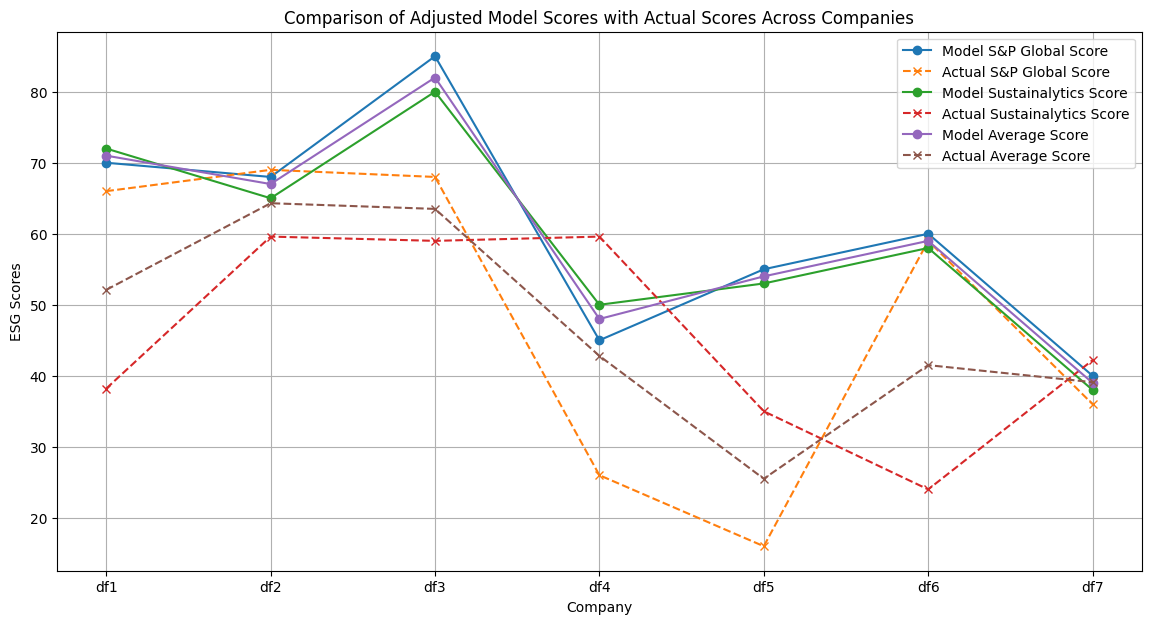

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 실제 평가 점수
actual_scores = pd.DataFrame({
    'S&P Global': [66, 69, 68, 26, 16, 59, 36],
    'Sustainalytics': [19.1, 29.8, 29.5, 29.8, 17.5, 12, 21.1]
}, index=['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7'])

# Sustainalytics 점수 2배 조정
actual_scores['Sustainalytics'] *= 2

# 평균 점수 계산
actual_scores['Average'] = actual_scores[['S&P Global', 'Sustainalytics']].mean(axis=1)

# 가정된 모델의 결과
model_scores = pd.DataFrame({
    'S&P Global Score': [70, 68, 85, 45, 55, 60, 40],
    'Sustainalytics Score': [72, 65, 80, 50, 53, 58, 38],
    'Average Score': [71, 67, 82, 48, 54, 59, 39]
}, index=['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7'])

# 실제 점수와 모델 점수 결합
scores = pd.concat([model_scores, actual_scores], axis=1)

# 각 기업별로 모델 점수와 실제 점수 비교
plt.figure(figsize=(14, 7))

# 각 평가 기준별로 점수 비교
for criterion in ['S&P Global', 'Sustainalytics', 'Average']:
    plt.plot(scores.index, scores[criterion + ' Score'], marker='o', linestyle='-', label=f'Model {criterion} Score')
    plt.plot(scores.index, scores[criterion], marker='x', linestyle='--', label=f'Actual {criterion} Score')

plt.title('Comparison of Adjusted Model Scores with Actual Scores Across Companies')
plt.xlabel('Company')
plt.ylabel('ESG Scores')
plt.legend()
plt.grid(True)
plt.show()
